### Import

In [1]:
from itertools import product
from collections import defaultdict

from os import PathLike
from typing import Union

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve

import logomaker as lm
import altair as alt
from sklearn.metrics import r2_score, auc
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Path

In [2]:
data_path = './Data/'

### Set Random Seed 

In [3]:
def set_seed(seed: int = 42) -> None:
    
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set as {seed}")
    
set_seed(17)

Random seed set as 17


### Read Data

In [4]:
train_df = pd.read_csv(data_path + 'Train_Enhancers.csv' , index_col=False)
test_df  = pd.read_csv(data_path + 'Test_Enhancers.csv'  , index_col=False)

In [5]:
train_df.head(2)

,seq,target,seq_len
0,TGACTCCCCAGCGGCCCCCTGCCCTGCAGGTATTTGCTGTCTCCTG...,1,276
1,ACAAAACTTTGTTCCCTGGCCAGACCTAGATATGAGAGAGTCTAGG...,1,236


In [6]:
test_df.head(2)

,seq,target,seq_len
0,TGTCTGCCTTCCCTCAGCCTGTGAGCACCTTGAGGACAGGTTCTGC...,1,353
1,CCCACACACAGTAATTATTATTGAGAGCTAACATATTTAACATACT...,1,293


In [7]:
print("Train:", train_df.shape)
print("Test: ", test_df.shape)

Train: (113548, 3)
Test:  (28356, 3)


### One-Hot Encoding

In [8]:
def one_hot_encode(seq):

    allowed = set("ACTGN")
    
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [9]:
s = one_hot_encode("NAGTACN")

print("NAGTACN:\n",s)
print("\nshape:",s.shape)

NAGTACN:
 [[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]]

shape: (7, 4)


### Train - Validation - Test Split

In [10]:
def quick_split(df, split_frac=0.8, verbose=False):

    cols = df.columns 
    df   = df.reset_index()

    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs  = idxs[split:]
    
    train_df = df[df.index.isin(train_idxs)]
    test_df  = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

In [11]:
train_df, valid_df, _, _ = train_test_split(train_df, train_df['target'], stratify=train_df['target'], test_size=0.10) 

In [12]:
print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test: ", test_df.shape)

Train: (102193, 3)
Valid: (11355, 3)
Test:  (28356, 3)


### Plot Distribution of Train - Validation - Test Data

In [13]:
def plot_train_val_test_hist(train_df, valid_df, test_df, bins=20):
    
    plt.figure(figsize=(6, 4))
    
    plt.hist(train_df['target'].values, bins=bins, label='train', alpha=0.5)
    plt.hist(valid_df['target'].values, bins=bins, label='val'  , alpha=0.7)
    plt.hist(test_df['target'].values , bins=bins, label='test' , alpha=0.4)
    
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

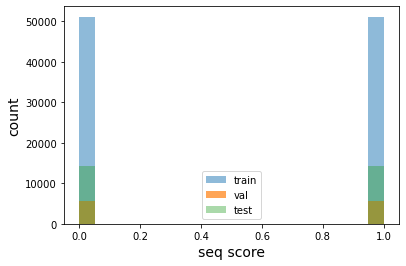

In [14]:
plot_train_val_test_hist(train_df, valid_df, test_df)

### Set GPU or CPU

In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


### Dataset

In [16]:
class SeqDatasetOHE(Dataset):

    def __init__(self, df, seq_col='seq', target_col='target'):

        self.seqs = list(df[seq_col].values)
        self.seq_len  = len(self.seqs[0])
        
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
        self.labels   = torch.tensor(df[target_col].values)
        
    def __len__(self): 
        return len(self.seqs)
    
    def __getitem__(self,idx):
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

### DataLoader 

In [17]:
def build_dataloaders(train_df, valid_df, seq_col='seq', target_col='target', batch_size=128, shuffle=True):
    
    train_ds = SeqDatasetOHE(train_df, seq_col=seq_col, target_col=target_col)
    valid_ds = SeqDatasetOHE(valid_df, seq_col=seq_col, target_col=target_col)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size)
    
    return train_dl, valid_dl

In [18]:
train_dl, valid_dl = build_dataloaders(train_df, valid_df)

### Define Deep Learning Models in Pytorch

### Basic CNN Model

In [19]:
class DNA_CNN(nn.Module):
    
    def __init__(self, seq_len, num_filters=16, kernel_size=8):
        
        super().__init__()
        
        self.seq_len  = seq_len
        self.conv_net = nn.Sequential(nn.Conv1d(4, num_filters, kernel_size=kernel_size),
                                      nn.ReLU(inplace=True),
                                      nn.Flatten(),
                                      nn.Linear(num_filters*(seq_len-kernel_size+1), 2)) 
        
    def forward(self, xb):
        
        xb  = xb.permute(0,2,1) 
        out = self.conv_net(xb)
                
        return out

### Define the training loop functions

In [20]:
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)

    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [21]:
def train_step(model, train_dl, loss_func, device, opt):

    model.train()
    
    tl = [] 
    ns = [] 
    
    for xb, yb in train_dl:

        xb, yb = xb.to(device), yb.to(device)
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        
        tl.append(t)
        ns.append(n)
    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

In [22]:
def val_step(model, val_dl, loss_func, device):

    model.eval()
    
    with torch.no_grad():
        
        vl = [] 
        ns = [] 
        
        for xb, yb in val_dl:
            
            xb, yb = xb.to(device), yb.to(device)
            v, n = loss_batch(model, loss_func, xb, yb)

            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss

In [23]:
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):

    train_losses = []    
    val_losses   = []
    
    for epoch in range(epochs):

        train_loss = train_step(model, train_dl, loss_func, device,opt)
        train_losses.append(train_loss)

        val_loss = val_step(model, val_dl, loss_func, device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses

In [24]:
def run_model(train_dl, val_dl, model, device, lr=0.01, epochs=30, lossf=None, opt=None):
    
    if opt:
        optimizer = opt
    else: 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    if lossf:
        loss_func = lossf
    else:
        loss_func = torch.nn.CrossEntropyLoss()

    train_losses, val_losses = fit(epochs, model, loss_func, optimizer, train_dl, val_dl, device)

    return train_losses, val_losses

### Run Models

### Convolution

In [25]:
seq_len = len(train_df['seq'].values[0])
print(seq_len)

400


In [26]:
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) 

DNA_CNN(
  (conv_net): Sequential(
    (0): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=6288, out_features=2, bias=True)
  )
)

In [27]:
cnn_train_losses, cnn_val_losses = run_model(train_dl, valid_dl, model_cnn, DEVICE)

/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


E0 | train loss: 0.638 | val loss: 0.622
E1 | train loss: 0.593 | val loss: 0.577
E2 | train loss: 0.560 | val loss: 0.555
E3 | train loss: 0.541 | val loss: 0.543
E4 | train loss: 0.530 | val loss: 0.534
E5 | train loss: 0.524 | val loss: 0.533
E6 | train loss: 0.518 | val loss: 0.526
E7 | train loss: 0.513 | val loss: 0.542
E8 | train loss: 0.509 | val loss: 0.519
E9 | train loss: 0.505 | val loss: 0.535
E10 | train loss: 0.501 | val loss: 0.513
E11 | train loss: 0.497 | val loss: 0.509
E12 | train loss: 0.494 | val loss: 0.506
E13 | train loss: 0.491 | val loss: 0.511
E14 | train loss: 0.487 | val loss: 0.510
E15 | train loss: 0.484 | val loss: 0.506
E16 | train loss: 0.481 | val loss: 0.496
E17 | train loss: 0.479 | val loss: 0.493
E18 | train loss: 0.476 | val loss: 0.553
E19 | train loss: 0.474 | val loss: 0.491
E20 | train loss: 0.472 | val loss: 0.492
E21 | train loss: 0.470 | val loss: 0.490
E22 | train loss: 0.467 | val loss: 0.486
E23 | train loss: 0.466 | val loss: 0.484
E2

### Loss Plot

In [28]:
def quick_loss_plot(data_label_list, loss_type="Loss", sparse_n=0):
    
    plt.figure(figsize=(10, 5))

    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='gray')
    plt.legend(fontsize=12)
    plt.tight_layout()

    ax = plt.gca() 
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True)) 
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()

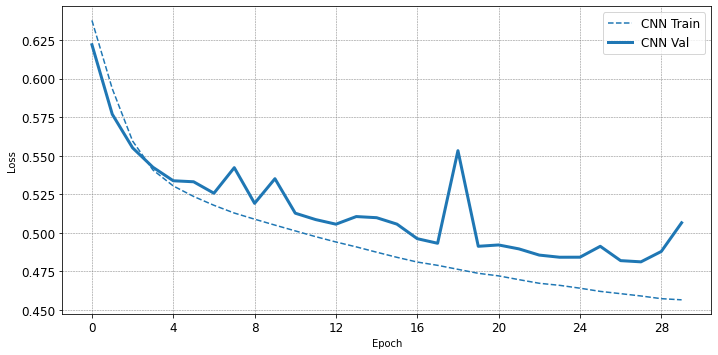

In [29]:
cnn_data_label = (cnn_train_losses, cnn_val_losses,"CNN")
quick_loss_plot([cnn_data_label])

### Check Model Predictions on Test

In [30]:
def test_pred(models, seqs, oracle, alt=False, datapane=False):
        
    for model_name, model in models:
        
        print(f"Running {model_name}")
         
        data = []
        
        for dna in seqs:
            s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            actual = oracle[dna]
            pred = model(s.float())
            pred = nn.Softmax()(pred)
            data.append([dna, actual, pred.cpu().data.numpy().argmax(), pred.cpu().data.numpy()[0][1]])
        
        df_con = pd.DataFrame(data, columns=['seq','truth','conv_pred', 'conv_prob'])
        
    return df_con

In [31]:
test_seqs = test_df['seq'].values
models = [("CNN", model_cnn)]
test_oracle = dict(test_df[['seq', 'target']].values)
test_result = test_pred(models, test_seqs, test_oracle)
test_result.head(3)

Running CNN


/tmp/ipykernel_51798/739935195.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = nn.Softmax()(pred)


,seq,truth,conv_pred,conv_prob
0,TGTCTGCCTTCCCTCAGCCTGTGAGCACCTTGAGGACAGGTTCTGC...,1,1,0.973347
1,CCCACACACAGTAATTATTATTGAGAGCTAACATATTTAACATACT...,1,0,0.279728
2,TGAAGGGCTTTAAACCCAGGCAGTCTGAATCCAGAACCCAAATGTC...,1,1,0.886980


### ROC

In [32]:
def ROC_curve(true_label, prediction_prob):
    
    AUC = roc_auc_score(true_label, prediction_prob)
    fpr, tpr, roc_thresholds = roc_curve(true_label, prediction_prob)

    fig, ax = plt.subplots(figsize=(4, 3), dpi=120)
    plt.plot(fpr, tpr, color='darkorange', lw=1.2, label='Model (AUC = {:.2f})'.format(AUC))
    plt.plot([0, 1], [0, 1], color='navy', lw=1.2, linestyle='--', label='Random (AUC = 0.50)')
    plt.xlim([-0.01, 1.00])
    plt.ylim([ 0.00, 1.02])
    plt.xlabel('False Positive Rate', fontsize=8)
    plt.ylabel('True Positive Rate', fontsize=8)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=8)
    plt.legend(loc="best", fontsize=8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()  
    for spine in ax.spines.values(): 
        spine.set_edgecolor('black')
    plt.show()

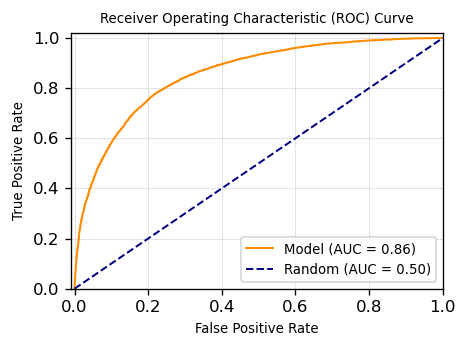

In [33]:
ROC_curve(test_result['truth'], test_result['conv_prob'])

### Precision-Recall Curve 

In [34]:
def PRC_REC_curve(true_label, prediction_prob):
    
    AP = average_precision_score(true_label, prediction_prob)
    precision, recall, pr_thresholds = precision_recall_curve(true_label, prediction_prob)
    no_skill = len(true_label[true_label == 1]) / len(true_label) 

    fig, ax = plt.subplots(figsize=(4, 3), dpi=120)
    plt.plot(recall, precision, color='darkorange', lw=1.2, label='Model (AP = {:.2f})'.format(AP))
    plt.plot([0, 1], [no_skill, no_skill], color='navy', lw=1.2, linestyle='--', label='No Skill (AP = {:.2f})'.format(no_skill))
    plt.xlim([-0.01, 1.00])
    plt.ylim([ 0.40, 1.02])
    plt.xlabel('Recall', fontsize=8)
    plt.ylabel('Precision', fontsize=8)
    plt.title('Precision-Recall Curve', fontsize=8)
    plt.legend(loc="best", fontsize=8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()  
    for spine in ax.spines.values(): 
        spine.set_edgecolor('black')
    plt.show()

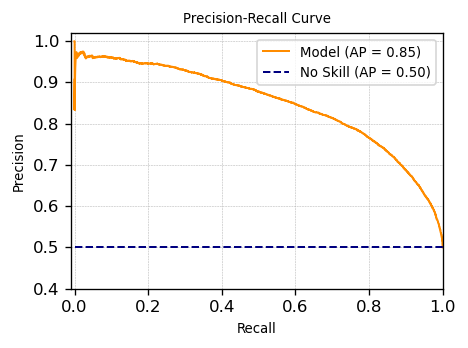

In [35]:
PRC_REC_curve(test_result['truth'], test_result['conv_prob'])

### Calibration 

In [36]:
def Calibration_curve(true_label, prediction_prob):
    
    fig, ax = plt.subplots(figsize=(5, 2.5), dpi=120)
    
    frac_of_pos, mean_pred_value = calibration_curve(true_label, prediction_prob, n_bins=10)

    plt.plot([0, 1], [0, 1], "--", label="Perfectly Calibrated", color='navy', lw=1.3)
    plt.plot(mean_pred_value, frac_of_pos, "*-", label='Model Calibration', lw=1.2, color='darkorange')

    plt.ylabel("Fraction of Positives", fontsize=8)
    plt.xlabel("Mean Predicted Value", fontsize=8)
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.title('Calibration Curve', fontsize=8)
    plt.legend(loc="best", fontsize=8)
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()  
    for spine in ax.spines.values(): 
        spine.set_edgecolor('black')
    plt.show()

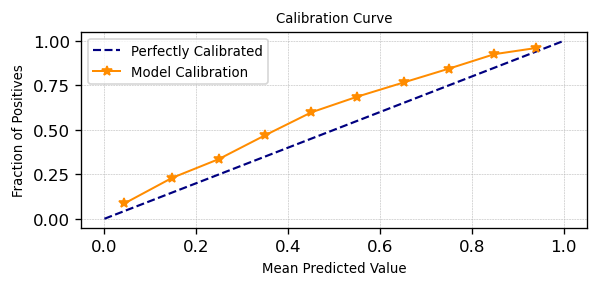

In [37]:
Calibration_curve(test_result['truth'], test_result['conv_prob'])

## Visualize convolutional filters

In [38]:
def get_conv_layers_from_model(model):

    model_children = list(model.children())
    
    model_weights = [] 
    conv_layers   = [] 
    bias_weights  = []
    counter = 0 

    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv1d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    
    return conv_layers, model_weights, bias_weights

In [39]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model_cnn)

Total convolutional layers: 1


In [40]:
def view_filters(model_weights, num_cols=4):
    
    model_weights = model_weights[0]
    num_filt   = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows   = int(np.ceil(num_filt/4))
    
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='bwr')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

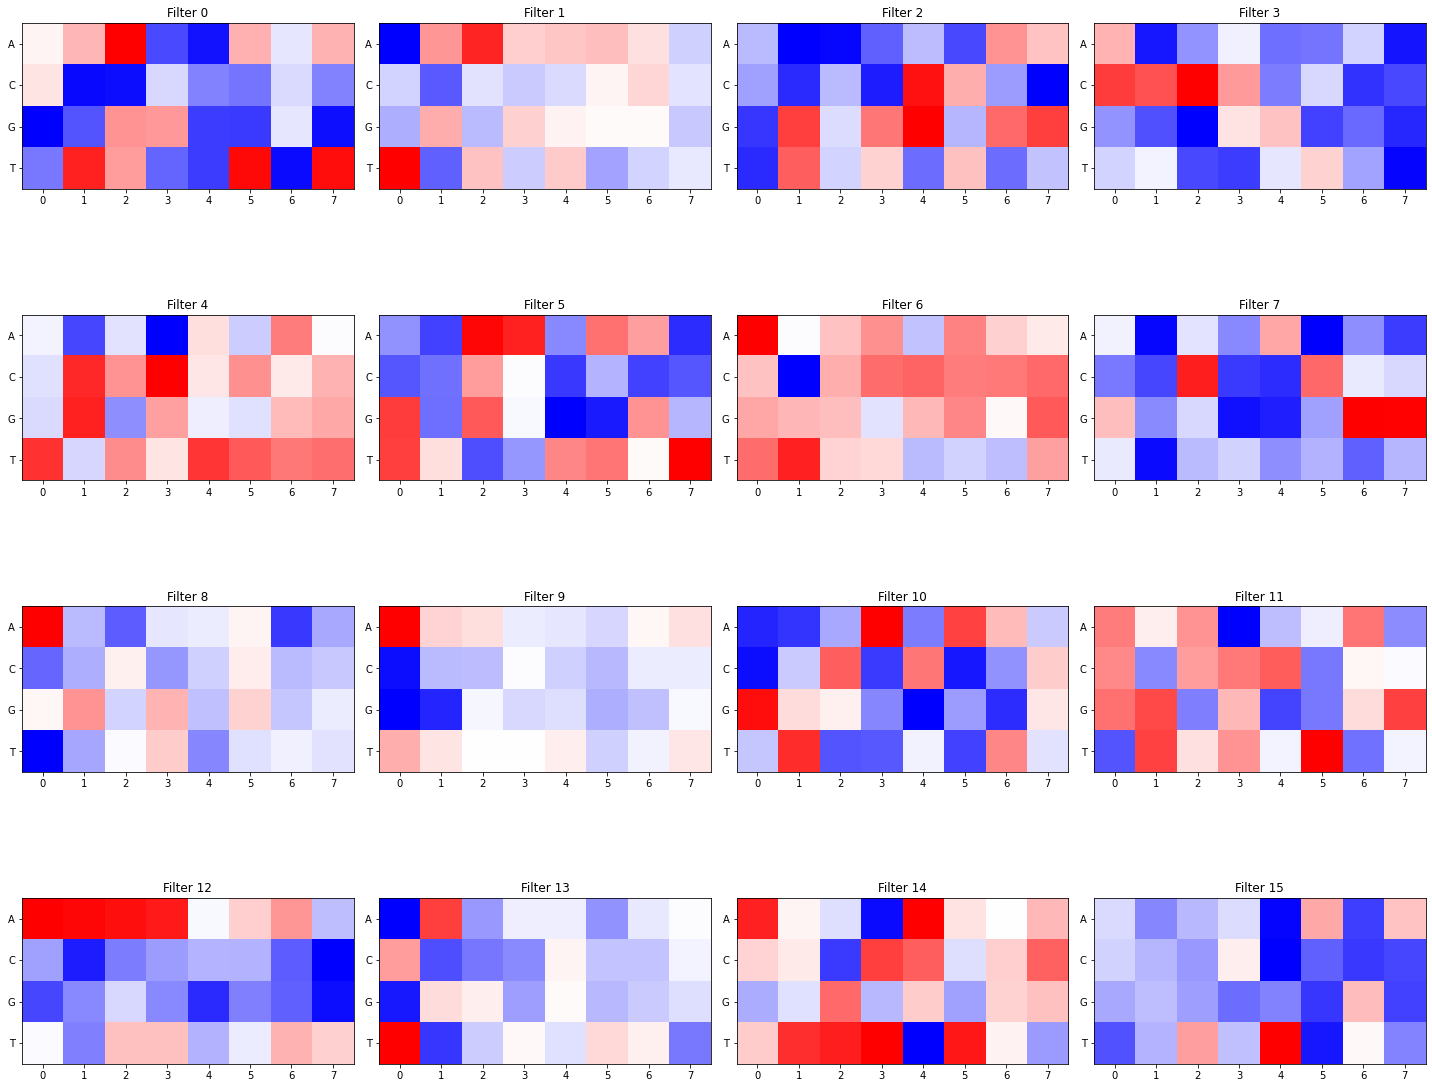

In [41]:
view_filters(model_weights)

![](images/filter_activation.png)

In [42]:
device = DEVICE
batch_size = 128
num_workers = 0

In [43]:
sdata_ds = SeqDatasetOHE(test_df, seq_col='seq', target_col='target')
sdataloader = DataLoader(sdata_ds, batch_size=batch_size)

In [44]:
DNA = ["A", "C", "G", "T"]
vocab_dict = {"DNA": ["A", "C", "G", "T"], 
              "RNA": ["A", "C", "G", "U"]}

In [45]:
def _get_first_conv_layer(model: nn.Module, 
                          device: str = "cpu"):

    model_children = list(model.children())
    
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv1d:
            first_layer = model_children[i]
            return first_layer.to(device)

        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    first_layer = child
                    return first_layer.to(device)
    print("No Conv1d layer found, returning None")
    
    return None

In [46]:
def _one_hot2token(one_hot, 
                   neutral_value=-1, 
                   consensus=False):

    if consensus:
        return np.argmax(one_hot, axis=0)
    tokens = np.tile(neutral_value, one_hot.shape[0])  
    seq_inds, dim_inds = np.where(one_hot==1)
    tokens[seq_inds] = dim_inds
    
    return tokens

In [47]:
def _get_vocab(vocab):
    if vocab == "DNA":
        return DNA
    elif vocab == "RNA":
        return RNA
    else:
        raise ValueError("Invalid vocab, only DNA or RNA are currently supported")

def _get_vocab_dict(vocab):
    return {l: i for i, l in enumerate(vocab)}

def _get_index_dict(vocab):
    return {i: l for i, l in enumerate(vocab)}

In [48]:
def _sequencize(tvec, 
                vocab="DNA", 
                neutral_value=-1,
                neutral_char="N"):

    vocab = _get_vocab(vocab) 
    index_dict = _get_index_dict(vocab)
    index_dict[neutral_value] = neutral_char
    
    return "".join([index_dict[i] for i in tvec])

In [49]:
def decode_seq(arr, 
               vocab="DNA", 
               neutral_value=-1,
               neutral_char="N"):

    if isinstance(arr, torch.Tensor):
        arr = arr.numpy()
        
    return _sequencize(
        tvec=_one_hot2token(arr, neutral_value),
        vocab=vocab,
        neutral_value=neutral_value,
        neutral_char=neutral_char,)

In [50]:
def decode_seqs(arr, 
                vocab="DNA", 
                neutral_char="N", 
                neutral_value=-1, 
                verbose=True):

    arr_list = [
        decode_seq(
            arr=arr[i],
            vocab=vocab,
            neutral_value=neutral_value,
            neutral_char=neutral_char,)
        for i in range(len(arr))]
    
    return np.array(arr_list)

In [51]:
def _get_activations_from_layer(layer: nn.Module, 
                                sdataloader: DataLoader, 
                                device: str = "cpu", 
                                vocab: str = "DNA"):

    activations = []
    sequences = []
    dataset_len = len(sdataloader.dataset)
    batch_size = sdataloader.batch_size
    for batch in sdataloader:
        x, y = batch

        sequences.append(decode_seqs(x.detach().cpu().numpy(), vocab=vocab, verbose=False))
        x = x.to(device)
        layer = layer.to(device)
        x  = x.permute(0,2,1)
        x = x.type(torch.DoubleTensor)
        layer = layer.type(torch.DoubleTensor)
        activations.append(F.relu(layer(x)).detach().cpu().numpy())
        np_act = np.concatenate(activations)
        np_seq = np.concatenate(sequences)
        
    return np_act, np_seq

In [52]:
def _k_largest_index_argsort(a: np.ndarray, k: int = 1) -> np.ndarray:
    
    idx = np.argsort(a.ravel())[:-k-1:-1]
    
    return np.column_stack(np.unravel_index(idx, a.shape))

In [53]:
def _get_filter_activators(activations: np.ndarray,
                           sequences: np.ndarray,
                           kernel_size: int,
                           num_filters: int = None,
                           method: str = "Alipanahi15",
                           threshold: float = 0.5,
                           num_seqlets: int = 100,):

    num_filters = num_filters if num_filters is not None else activations.shape[1]
    
    if method == "Alipanahi15":
        assert (threshold is not None), "Threshold must be specified for Alipanahi15 method."
        filter_activators = []
        for i, filt in tqdm(
            enumerate(range(num_filters)),
            desc=f"Getting filter activators for {num_filters} filters",
            total=num_filters,
        ):
            single_filter = activations[:, filt, :]
            max_val = np.max(single_filter)
            activators = []
            for i in range(len(single_filter)):
                starts = np.where(single_filter[i] >= max_val * threshold)[0]
                for start in starts:
                    activators.append(sequences[i][start : start + kernel_size])
            filter_activators.append(activators)
            
    elif method == "Minnoye20":
        assert (num_seqlets is not None), "num_seqlets must be specified for Minnoye20 method."
        filter_activators = []
        for i, filt in enumerate(range(num_filters)):
            single_filter = activations[:, filt, :]
            inds = _k_largest_index_argsort(single_filter, num_seqlets)
            filter_activators.append(
                [
                    seq[inds[i][1] : inds[i][1] + kernel_size]
                    for i, seq in enumerate(sequences[inds[:, 0]])
                ])
            
    return filter_activators

In [54]:
def _get_pfms(filter_activators: np.ndarray, 
              kernel_size: int, 
              vocab: str = "DNA",):  

    filter_pfms = {}
    vocab = _get_vocab(vocab)
    
    for i, activators in enumerate(filter_activators):
        pfm = {
            vocab[0]: np.zeros(kernel_size),
            vocab[1]: np.zeros(kernel_size),
            vocab[2]: np.zeros(kernel_size),
            vocab[3]: np.zeros(kernel_size),
            "N": np.zeros(kernel_size),}
        
        for seq in activators:
            for j, nt in enumerate(seq):
                pfm[nt][j] += 1
        filter_pfm = pd.DataFrame(pfm)
        filter_pfm = filter_pfm.drop("N", axis=1)
        filter_pfms[i] = filter_pfm
        filter_pfms[i] = filter_pfms[i].div(filter_pfms[i].sum(axis=1), axis=0)
        
    return filter_pfms

In [55]:
def generate_pfms_sdata(sdataloader,
                        model: nn.Module,
                        sdata,
                        method: str = "Alipanahi15",
                        vocab: str = "DNA",
                        num_filters: int = None,
                        threshold: float = 0.5,
                        num_seqlets: int = 100,
                        batch_size: int = None,
                        num_workers: int = None,
                        device: str = "cpu",
                        transform_kwargs: dict = {},
                        key_name: str = "pfms",
                        prefix: str = "",
                        suffix: str = "",
                        copy: bool = False,
                        **kwargs):
    
    device = "cuda" 
    batch_size = 128
    num_workers = 0
        
    first_layer = _get_first_conv_layer(model, device=device)
    
    activations, sequences = _get_activations_from_layer(first_layer, sdataloader, device=device, vocab=vocab)
    
    filter_activators = _get_filter_activators(activations, sequences, first_layer.kernel_size[0],
                                               num_filters=num_filters, method=method, threshold=threshold,
                                               num_seqlets=num_seqlets,)
    
    filter_pfms = _get_pfms(filter_activators, first_layer.kernel_size[0], vocab=vocab)
    
    return filter_pfms 

In [56]:
filters = generate_pfms_sdata(sdataloader, model=model_cnn, sdata=test_df, method="Minnoye20")

In [57]:
def filter_viz(sdata,
               filter_id: Union[str, int],
               uns_key: str = "pfms",
               vocab: str = "DNA",
               title: str = None,
               return_ax: bool = False,
               save: str = None,
               **kwargs,):

    pfm = sdata[filter_id]
    
    if isinstance(pfm, np.ndarray):
        pfm = pd.DataFrame(pfm, columns=vocab_dict[vocab])
    vocab = vocab_dict[vocab]
    
    if pfm[vocab[0]].dtype == "float64":
        pfm.fillna(0.25, inplace=True)
        info_mat = lm.transform_matrix(
            pfm, 
            from_type="probability", 
            to_type="information")
        
    elif pfm[vocab.keys[0]].dtype == "int64":
        pfm.fillna(1, inplace=True)
        info_mat = lm.transform_matrix(
            pfm, 
            from_type="counts", 
            to_type="information", 
            allow_nan=True)
        
    if "N" in pfm.columns:
        info_mat = info_mat.drop("N", axis=1)
    logo = lm.Logo(info_mat, **kwargs)
    logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt="%d", fontsize=14)
    logo.style_spines(visible=False)
    logo.style_spines(spines=["left", "bottom"], visible=True, linewidth=2)
    logo.ax.set_ylim([0, 2])
    logo.ax.set_yticks([0, 1, 2])
    logo.ax.set_yticklabels(["0", "1", "2"])
    logo.ax.set_ylabel("bits")
    logo.ax.set_title(title if title is not None else filter_id)
    
    if save is not None:
        _save_fig(save)
        
    if return_ax:
        return logo.ax

In [58]:
def multifilter_viz(sdata,
                    filter_ids: list,
                    num_rows: int = None,
                    num_cols: int = None,
                    uns_key: str = "pfms",
                    titles: list = None,
                    figsize=(12,10),
                    save: PathLike = None,
                    **kwargs,):

    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    for i in range(num_rows):
        for j in range(num_cols):
            filter_id = filter_ids[i * num_cols + j]
            filter_viz(
                sdata,
                filter_id=filter_id,
                uns_key=uns_key,
                ax=ax.flatten()[i * num_cols + j],
                title=titles[i * num_cols + j] if titles is not None else filter_id,
                save=None,
                **kwargs,)

    plt.tight_layout()
    if save is not None:
        _save_fig(save) 

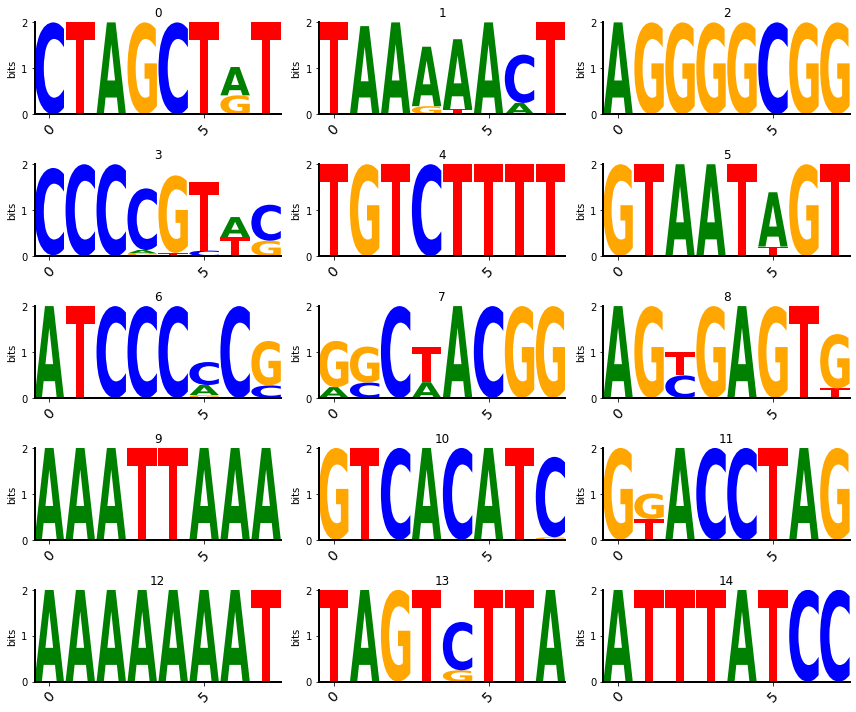

In [59]:
multifilter_viz(filters, filter_ids=list(filters.keys()), num_rows=5, num_cols=3)